# Using wavelet methods to analyze GPS recordings of slow slip events

## Maximum overlap discrete wavelet transform

We will now perform the analysis of the GPS data using the MODWT.

We begin by importing the Python modules that we will need during the analysis.

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from math import cos, floor, pi, sin, sqrt
from scipy.io import loadmat

import sys
sys.path.append("../src")
import DWT
import MODWT
import date

%matplotlib inline

We perform the same preprocessing to the data that we have done for the DWT analysis.

In [2]:
# Choose the station
station = 'PGC5'
direction = 'lon'
dataset = 'cleaned'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction
# Load the data
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]
# Correct for the repeated value
dt = np.diff(time)
gap = np.where(dt < 1.0 / 365.0 - 0.001)[0]
time[gap[0] + 1] = time[gap[0] + 2]
time[gap[0] + 2] = 0.5 * (time[gap[0] + 2] + time[gap[0] + 3])
# Look for gaps greater than 2 days
days = 2
dt = np.diff(time)
gap = np.where(dt > days / 365.0 + 0.001)[0]
# Select a subset of the data without big gaps
ibegin = 2189
iend = 5102
time_sub = time[ibegin + 1 : iend + 1]
disp_sub = disp[ibegin + 1 : iend + 1]
# Fill the missing values by interpolation
dt = np.diff(time_sub)
gap = np.where(dt > 1.0 / 365.0 + 0.001)[0]
for i in range(0, len(gap)):
    time_sub = np.insert(time_sub, gap[i] + 1, time_sub[gap[i]] + 1.0 / 365.0)
    disp_sub = np.insert(disp_sub, gap[i] + 1, 0.5 * (disp_sub[gap[i]] + disp_sub[gap[i] + 1]))
    gap[i : ] = gap[i : ] + 1

We set the same times for the ETS events as in the previous analysis.

In [3]:
time_ETS = [2000.9583, 2002.1250, 2003.1250, 2004.0417, 2004.5417, 2005.7083, 2007.0833, 2008.375, 2009.375, \
            2010.6667, 2011.6667, 2012.7083, 2013.7500, 2014.9167, 2016.0000, 2017.1667]

We also need to download the tremor catalog.

In [4]:
# Load tremor data from the catalog downloaded from the PNSN
filename = '../data/timelags/08_01_2009_11_26_2014.txt'
day = np.loadtxt(filename, dtype=np.str, usecols=[0], skiprows=16)
hour = np.loadtxt(filename, dtype=np.str, usecols=[1], skiprows=16)
nt = np.shape(day)[0]
time_tremor = np.zeros(nt)
for i in range(0, nt):
    time_tremor[i] = date.string2day(day[i], hour[i])
location = np.loadtxt('../data/timelags/08_01_2009_11_26_2014.txt', usecols=[2, 3], skiprows=16)
lat_tremor = location[:, 0]
lon_tremor = location[:, 1]
k = (lat_tremor >= 47.5) & (lat_tremor <= 49.5)

We choose the maximum level for which we want to perform the MODWT analysis. However, we no longer need the length of the data to be a multiple of 2**J.

In [5]:
J = 6
time = time_sub
disp = disp_sub

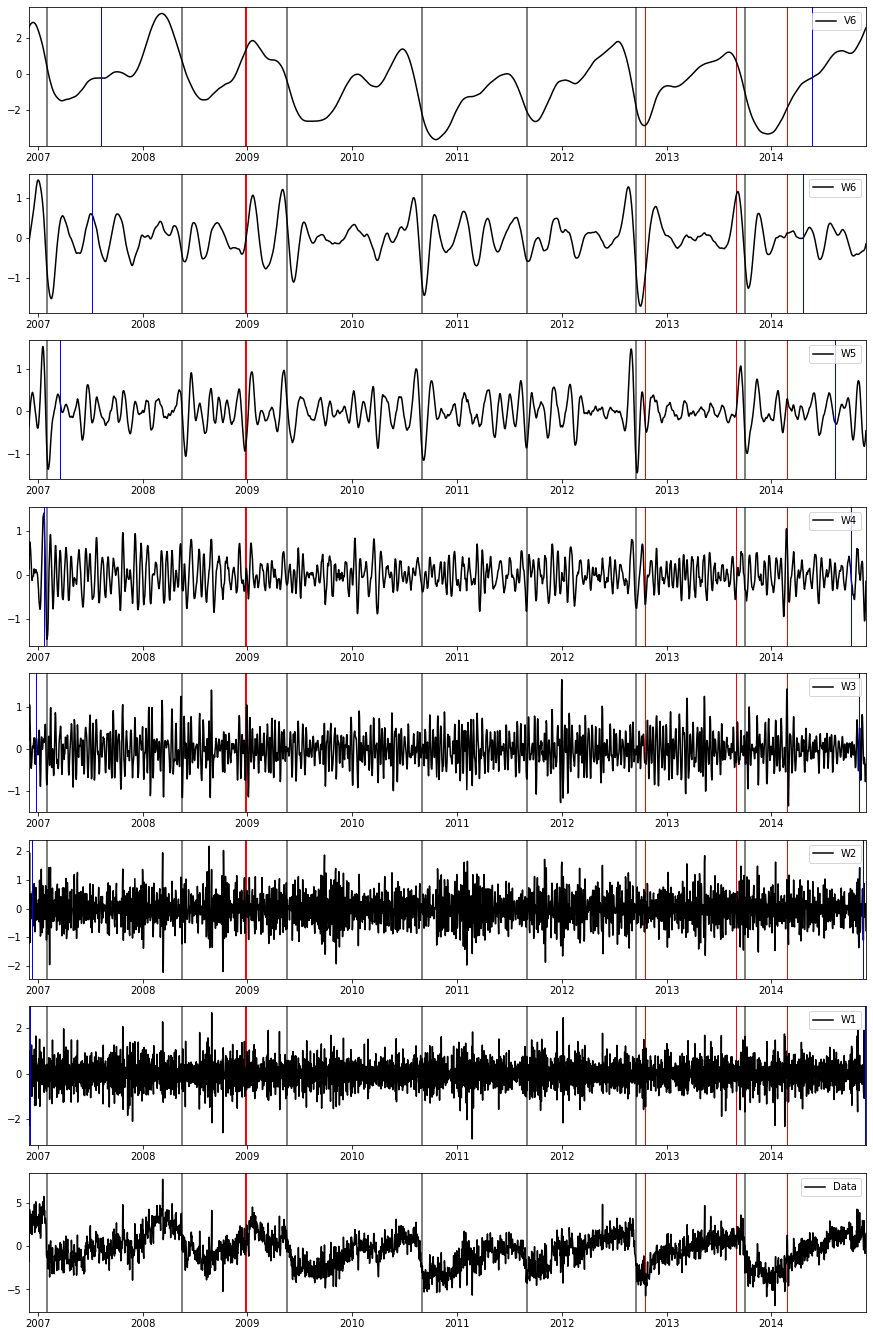

In [6]:
# Compute MODWT
[W, V] = MODWT.pyramid(disp, 'LA8', J)
(nuH, nuG) = DWT.get_nu('LA8', J)

N = np.shape(disp)[0]
L = 8
plt.figure(1, figsize=(15, 24))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot wavelet coefficients at each level
for j in range(1, J + 1):
    Wj = W[j - 1]
    plt.subplot2grid((J + 2, 1), (J + 1 - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    plt.plot(time, np.roll(Wj, nuH[j - 1]), 'k', label = 'W' + str(j))
    Lj = (2 ** j - 1) * (L - 1) + 1
    plt.axvline(time[Lj - 2 - abs(nuH[j - 1])], linewidth=1, color='blue')
    plt.axvline(time[N - abs(nuH[j - 1])], linewidth=1, color='blue')
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot scaling coefficients for the last level
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, np.roll(V, nuG[J - 1]), 'k', label = 'V' + str(J))
Lj = (2 ** J - 1) * (L - 1) + 1
plt.axvline(time[Lj - 2 - abs(nuG[J - 1])], linewidth=1, color='blue')
plt.axvline(time[N - abs(nuG[J - 1])], linewidth=1, color='blue')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

Let us now look at the details and the smooth of the MODWT analysis.

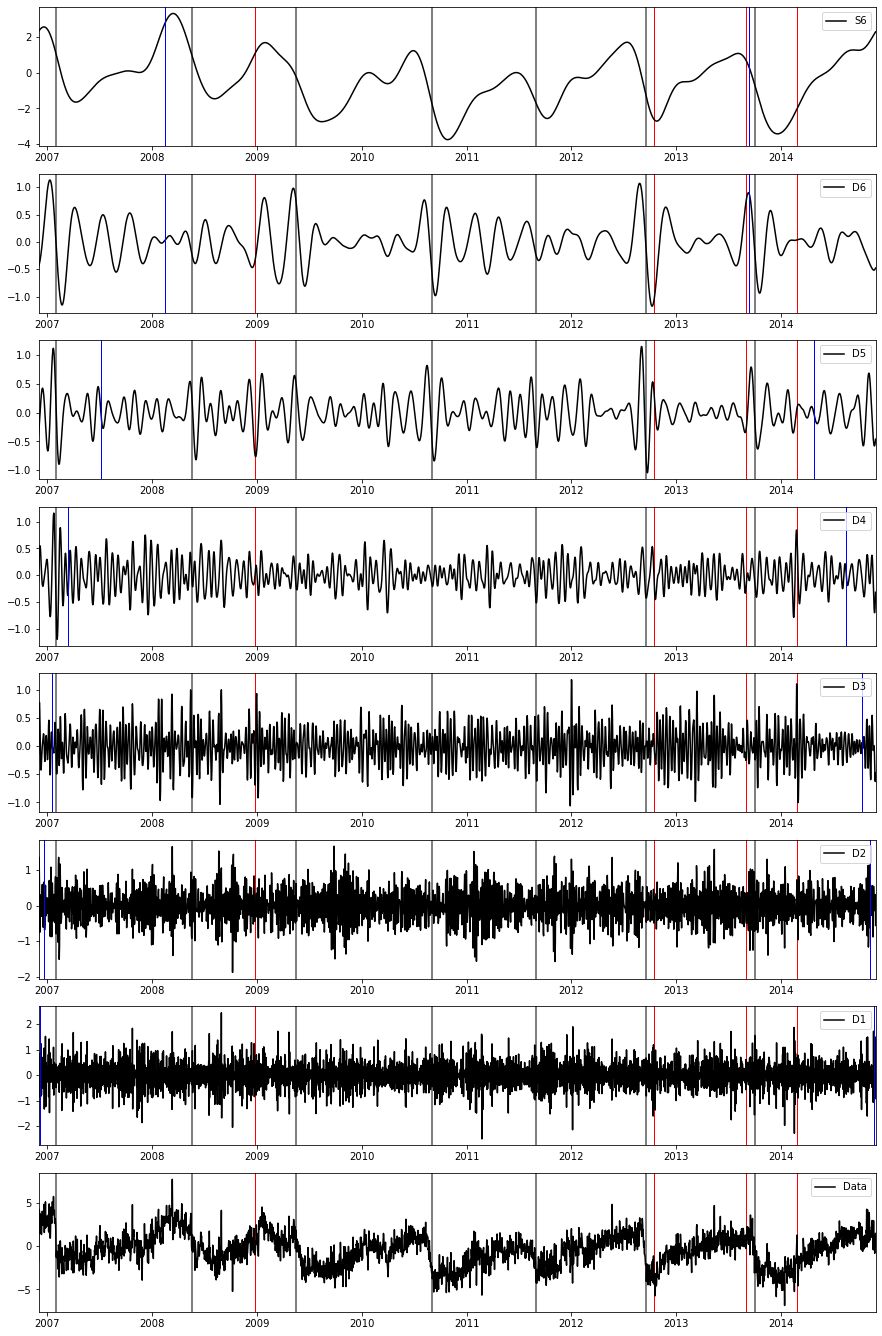

In [7]:
(D, S) = MODWT.get_DS(disp, W, 'LA8', J)

plt.figure(1, figsize=(15, 24))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot details at each level
for j in range(0, J):
    plt.subplot2grid((J + 2, 1), (J - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    plt.plot(time, D[j], 'k', label='D' + str(j + 1))
    Lj = (2 ** (j + 1) - 1) * (L - 1) + 1
    plt.axvline(time[Lj - 2], linewidth=1, color='blue')
    plt.axvline(time[N - Lj + 1], linewidth=1, color='blue')
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot smooth for the last level
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, S[J], 'k', label='S' + str(J))
Lj = (2 ** J - 1) * (L - 1) + 1
plt.axvline(time[Lj - 2], linewidth=1, color='blue')
plt.axvline(time[N - Lj + 1], linewidth=1, color='blue')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

Finally, let us now plot at the same time the 5th and the 6th level details and the cumulative number of tremor.

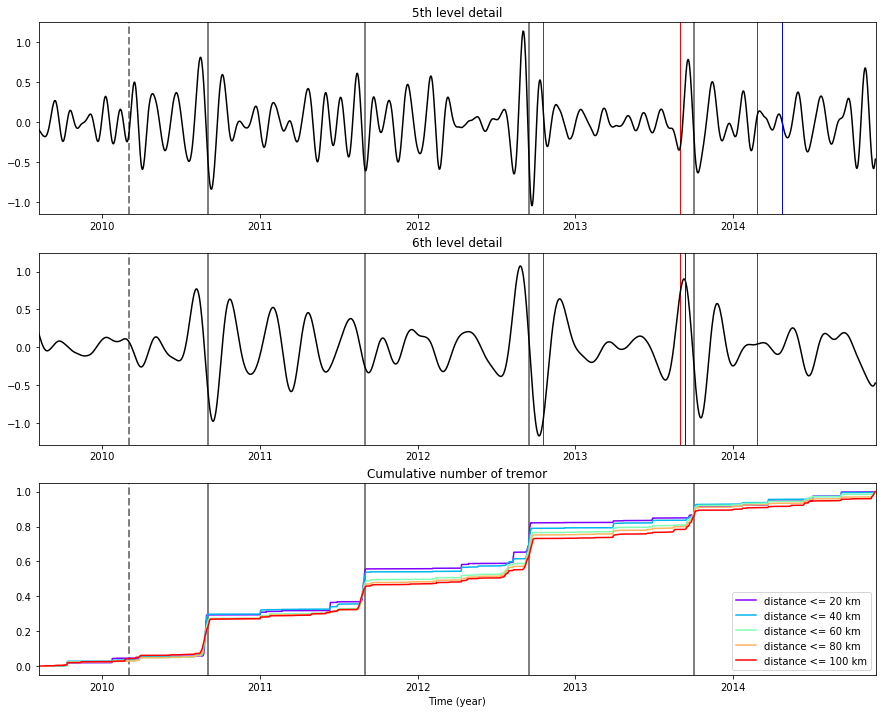

In [8]:
plt.figure(1, figsize=(15, 12))

# Plot 5th detail of DWT analysis
plt.subplot(311)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, D[4], 'k', label='Data')
Lj = (2 ** 5 - 1) * (L - 1) + 1
plt.axvline(time[Lj - 2], linewidth=1, color='blue')
plt.axvline(time[N - Lj + 1], linewidth=1, color='blue')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('5th level detail')

# Plot 6th detail of DWT analysis
plt.subplot(312)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(time, D[5], 'k', label='Data')
Lj = (2 ** 6 - 1) * (L - 1) + 1
plt.axvline(time[Lj - 2], linewidth=1, color='blue')
plt.axvline(time[N - Lj + 1], linewidth=1, color='blue')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('6th level detail')

# Compute the tremor tme for different distances from the GPS station
a = 6378.136
e = 0.006694470
lat0 = 48.65
lon0 = -123.45
dx = (pi / 180.0) * a * cos(lat0 * pi / 180.0) / sqrt(1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0))
dy = (3.6 * pi / 648.0) * a * (1.0 - e * e) / ((1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0)) ** 1.5)
dist = np.sqrt(np.power((lat_tremor - lat0) * dy, 2.0) + np.power((lon_tremor - lon0) * dx, 2.0))
dists = [20.0, 40.0, 60.0, 80.0, 100.0]
times = []
for i in range(0, len(dists)):
    k = dist <= dists[i]
    times.append(time_tremor[k])

# Plot cumulative number of tremor
plt.subplot(313)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
plt.axvline(2010.1667, linewidth=2, linestyle='--', color='grey')
colors = cm.rainbow(np.linspace(0, 1, len(dists)))
for time_dist, distance, c in zip(times, dists, colors):
    nt = np.shape(time_dist)[0]
    plt.plot(np.sort(time_dist), (1.0 / nt) * np.arange(0, len(time_dist)), color=c, \
        label='distance <= {:2.0f} km'.format(distance))
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.xlabel('Time (year)')
plt.title('Cumulative number of tremor')
plt.legend(loc=4)

plt.show()